### Can tools detect exon duplications? 

We will evaluate:

* [exonerate](https://www.ebi.ac.uk/about/vertebrate-genomics/software/exonerate-manual)
* [gmap](http://research-pub.gene.com/gmap/src/README)
* [spaln2](https://github.com/ogotoh/spaln)



In [1]:
%load_ext autoreload
%autoreload 2
from fun import *

In [2]:
fasta_GRCh38_seq_with_dup = SeqIO.parse(open('GRCh38_with_coding_exon_dup.fa'),'fasta')
fasta_GRCh38_seq_with_dup = { fasta.id : str(fasta.seq) for fasta in fasta_GRCh38_seq_with_dup}

In [3]:
prot_seq = SeqIO.parse(open('genes_with_dup_original_prot_seq_.fa'),'fasta')
prot_seq = { fasta.id : str(fasta.seq) for fasta in prot_seq}

In [4]:
with open('../files/GRCh38_duplicated_coding_exons_coords.pkl', 'rb') as handle:
    dups_GRCh38_gene_coords = pickle.load(handle)


### exonerate

* choose model
- protein to genome model

protein2genome
This model allows alignment of a protein sequence to genomic DNA. This is similar to the protein2dna model, with the addition of modelling of introns and intron phases. This model is simliar to those used by genewise.

”cigar" output

In [5]:
#  !exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_coding_exon_dup.fa --model protein2genome --showtargetgff True > Exonerate/exon_showgff_protein2genome_ce_dup.out.txt 


In [6]:
#parse exonerate output
ex_out_fname = 'Exonerate/exon_showgff_protein2genome_ce_dup.out.txt'
ex_format = 'exonerate-text'

In [7]:
hits_feature_intervals = parse_exonerate_output(ex_format, ex_out_fname)

In [8]:
mutated_genes = {value['seq'][0]: key.split('gene:')[1] for key, value in dups_GRCh38_gene_coords.items()}

overlaping_queries_genes = {}
for prot_id, hits in hits_feature_intervals.items():
    for g, hit in enumerate(hits):
        fragments = list(hit['exons']['hit'].values())
        for i in list(mutated_genes.keys()):
            if get_overlap((fragments[0][0], fragments[-1][0]), i) > 1:
                overlaping_queries_genes[prot_id] = (mutated_genes[i], g)
                
all_qresult = list(SearchIO.parse(ex_out_fname, ex_format))
hits_feature_intervals = {}
for query in all_qresult:
    id_ = query.id.rsplit('.')[0]
    if id_ not in hits_feature_intervals:
        hits_feature_intervals[id_] = []
    for hit in query:
        hit_dict = {}
        for hsp in hit:
            hit_dict['exons'] = {'query': {'exon_' + str(i): HSPFragment.query_range  
                                            for i, HSPFragment in enumerate(hsp.fragments,1)},
                                 'hit': {'exon_' + str(i): HSPFragment.hit_range
                                          for i, HSPFragment in enumerate(hsp.fragments,1)}}
            hit_dict['introns'] = {'intron_' + str(i): j 
                                   for i, j in enumerate(hsp.hit_inter_ranges,1)}
            hit_dict['align_features'] = {feature: coord for feature, 
                                                              coord in sorted({**hit_dict['introns'],
                                                                               **hit_dict['exons']['hit']}.items(),
                                                                              key=lambda item: item[1][0])}
    hits_feature_intervals[id_].append(hit_dict)


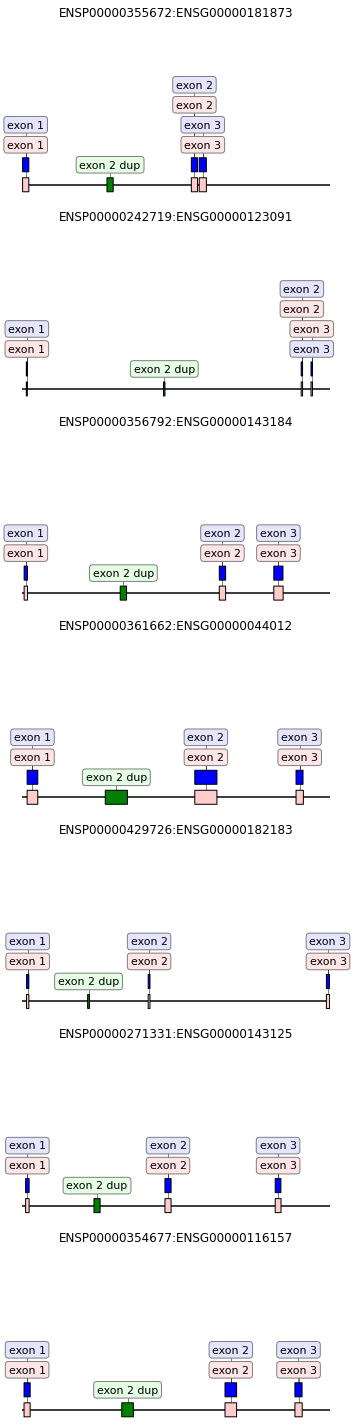

In [9]:
fig, ax = plt.subplots(len(overlaping_queries_genes), figsize=(5,20))
plt.tight_layout()
exon_dup = 2
for hit_idx, (prot_id, gene_id) in enumerate(overlaping_queries_genes.items()):
    gene_id, hit_n = gene_id
    gs, ge = dups_GRCh38_gene_coords['gene:'+gene_id]['seq'][0]
    features = []
    idx_ = 1
    for exon_id, exon_coords in dups_GRCh38_gene_coords['gene:'+gene_id]['coding_exons_dups'].items():
        for coord in exon_coords:
            #print(idx_)
            s, e = coord
            color="#ffcccc"
            labl = 'exon ' + str(idx_)
            if idx_ == exon_dup:
                color = 'green'
                labl = 'exon ' + str(idx_) + ' dup'
            if idx_ > 2:
                idx = idx_ - 1
                labl = 'exon ' + str(idx)
            idx_ += 1
            features.append(GraphicFeature(start=s, end=e, color=color,
                                           label=labl))
            
            
    for idx, query_feat_coord in enumerate([value for key, value in hits_feature_intervals[prot_id][hit_n]['align_features'].items() if 'exon' in key],1):
        qs, qe = query_feat_coord
        labl = 'exon ' + str(idx)
        features.append(GraphicFeature(start=qs, end=qe, color="blue",label=labl))
    record = GraphicRecord(first_index = gs, sequence_length = ge-gs, features=features)
    ax[hit_idx].set_title(prot_id + ':' + gene_id, loc='center')
    #ax[hit_idx].text(0,0,prot_id, ha="right", va="center")
    record.plot(ax=ax[hit_idx],figure_width=5,with_ruler=False)
plt.savefig('figs.jpg', bbox_inches='tight') 
    
    

##### Will exonerate find the two possible alignments in the same region where the duplication is, or does it require the alignments to hit different parts of the genome sequence?


In [ ]:
# !exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --bestn 2 --showtargetgff True > exonerate_bestn_2_showgff_protein2genome.out.txt

### gmap

In [ ]:
# !gmap -g GRCh38_with_exon_dup.fa -A genes_with_dup_original_prot_seq.fa > gmap.out.txt

In [ ]:
# !cat gmap.out.txt

### spaln

In [ ]:
# !spaln -S 1 GRCh38_with_exon_dup.fa genes_with_dup_original_prot_seq.fa > spaln.out.txt